In [ ]:
# FedSGD_vs_Central.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np
import random

# -------------------------
# Reproducibility
seed = 12345
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Tiny model (simple 2-layer MLP for MNIST)
class TinyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------------
# Config
M = 3                      # number of clients
batch_full = True          # use entire dataset as one batch for central
num_rounds = 15
lr = 0.01
train_subset_size = 1200   # total training examples (small for speed)
val_size = 500
device = device

# -------------------------
# Data: MNIST small subset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# pick a random subset of the train set (so experiment is fast)
indices = list(range(len(mnist_train)))
random.shuffle(indices)
selected = indices[:train_subset_size + val_size]
train_idxs = selected[:train_subset_size]
val_idxs = selected[train_subset_size:train_subset_size + val_size]

train_data = Subset(mnist_train, train_idxs)
val_data = Subset(mnist_train, val_idxs)

# split train_data evenly IID among M clients
assert train_subset_size % M == 0, "Make sure train_subset_size divisible by M"
per_client = train_subset_size // M
client_subsets = []
for i in range(M):
    s = list(range(i*per_client, (i+1)*per_client))
    # map to original indices
    client_idxs = [train_idxs[idx] for idx in s]
    client_subsets.append(Subset(mnist_train, client_idxs))

# central combined dataset
central_dataset = ConcatDataset(client_subsets)

# dataloaders
val_loader = DataLoader(val_data, batch_size=256, shuffle=False)
# client loaders (each uses full local set as a single batch)
client_loaders = [DataLoader(sub, batch_size=per_client, shuffle=False) for sub in client_subsets]
central_loader = DataLoader(central_dataset, batch_size=train_subset_size if batch_full else 256, shuffle=False)

# -------------------------
# Helper: copy model weights
def copy_model(src, dst):
    for p_src, p_dst in zip(src.parameters(), dst.parameters()):
        p_dst.data.copy_(p_src.data)

# helper: extract grads into list (deep copy)
def grads_from_model(model):
    grads = []
    for p in model.parameters():
        if p.grad is None:
            grads.append(torch.zeros_like(p.data))
        else:
            grads.append(p.grad.detach().clone())
    return grads

# helper: set grads into a model (used to accumulate)
def add_to_tensor_list(tlist, otherlist, alpha=1.0):
    for t, o in zip(tlist, otherlist):
        t.add_(o, alpha=alpha)

# helper: apply manual SGD step (no momentum)
def apply_update(model, grad_list, lr):
    for p, g in zip(model.parameters(), grad_list):
        p.data.add_( -lr * g )

# -------------------------
# Init models (same weights)
model_init = TinyMLP().to(device)
model_fed = TinyMLP().to(device)
model_cent = TinyMLP().to(device)
copy_model(model_init, model_fed)
copy_model(model_init, model_cent)

criterion = nn.CrossEntropyLoss(reduction="mean")

# training loop
for rnd in range(1, num_rounds+1):
    # ---------- FedSGD: each client computes gradient on entire local set ----------
    # We'll accumulate averaged gradients here
    averaged_grads = None

    for i, loader in enumerate(client_loaders):
        model_temp = TinyMLP().to(device)
        copy_model(model_fed, model_temp)   # start from current global model
        model_temp.train()
        # compute gradient on client's whole local dataset (one backward)
        for xb, yb in loader:   # loader has exactly one batch = entire local data
            xb, yb = xb.to(device), yb.to(device)
            logits = model_temp(xb)
            loss = criterion(logits, yb)
            break   # single full-batch
        # zero grads then backward
        for p in model_temp.parameters():
            if p.grad is not None:
                p.grad.zero_()
        loss.backward()

        # extract grads
        client_grads = grads_from_model(model_temp)
        # weighted average: Ni are equal so simple average
        if averaged_grads is None:
            averaged_grads = [g.clone() for g in client_grads]
        else:
            add_to_tensor_list(averaged_grads, client_grads, alpha=1.0)

    # divide by M to get average
    for g in averaged_grads:
        g.div_(M)

    # apply update to global fed model
    apply_update(model_fed, averaged_grads, lr)

    # ---------- Centralized SGD: compute gradient on entire combined dataset ----------
    model_cent.train()
    # one full-batch over whole data
    for xb, yb in central_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model_cent(xb)
        loss_cent = criterion(logits, yb)
        break
    # zero grads
    for p in model_cent.parameters():
        if p.grad is not None:
            p.grad.zero_()
    loss_cent.backward()
    central_grads = grads_from_model(model_cent)
    apply_update(model_cent, central_grads, lr)

    # ---------- Evaluation & comparison ----------
    # compute norm of parameter differences
    diff_norm = 0.0
    sq = 0.0
    for p_f, p_c in zip(model_fed.parameters(), model_cent.parameters()):
        d = (p_f.data - p_c.data).float()
        sq += (d.view(-1).double() @ d.view(-1).double()).item()
    diff_norm = float(np.sqrt(sq))

    # compute training loss for Fed and Central on whole training data (for monitoring)
    def eval_loss_accuracy(model, dataloader):
        model.eval()
        total_loss = 0.0
        total_correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in dataloader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                lossv = criterion(logits, yb)
                total_loss += lossv.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                total_correct += (preds == yb).sum().item()
                total += xb.size(0)
        return (total_loss / total, total_correct / total)
    train_loader_all = DataLoader(central_dataset, batch_size=256, shuffle=False)

    fed_train_loss, fed_train_acc = eval_loss_accuracy(model_fed, train_loader_all)
    cent_train_loss, cent_train_acc = eval_loss_accuracy(model_cent, train_loader_all)
    val_loss_fed, val_acc_fed = eval_loss_accuracy(model_fed, val_loader)
    val_loss_cent, val_acc_cent = eval_loss_accuracy(model_cent, val_loader)

    print(f"Round {rnd:02d} | diff_norm={diff_norm:.6e} | fed_train_loss={fed_train_loss:.4f} acc={fed_train_acc:.4f} | cent_train_loss={cent_train_loss:.4f} acc={cent_train_acc:.4f} | val_acc_fed={val_acc_fed:.4f} val_acc_cent={val_acc_cent:.4f}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.75MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.67MB/s]


Round 01 | diff_norm=1.226408e-08 | fed_train_loss=2.2976 acc=0.1050 | cent_train_loss=2.2976 acc=0.1050 | val_acc_fed=0.0900 val_acc_cent=0.0900
Round 02 | diff_norm=1.481644e-08 | fed_train_loss=2.2955 acc=0.1108 | cent_train_loss=2.2955 acc=0.1108 | val_acc_fed=0.0880 val_acc_cent=0.0880
Round 03 | diff_norm=1.769493e-08 | fed_train_loss=2.2934 acc=0.1183 | cent_train_loss=2.2934 acc=0.1183 | val_acc_fed=0.0920 val_acc_cent=0.0920
Round 04 | diff_norm=2.122398e-08 | fed_train_loss=2.2914 acc=0.1208 | cent_train_loss=2.2914 acc=0.1208 | val_acc_fed=0.0920 val_acc_cent=0.0920
Round 05 | diff_norm=2.424248e-08 | fed_train_loss=2.2893 acc=0.1258 | cent_train_loss=2.2893 acc=0.1258 | val_acc_fed=0.0960 val_acc_cent=0.0960
Round 06 | diff_norm=2.682791e-08 | fed_train_loss=2.2872 acc=0.1317 | cent_train_loss=2.2872 acc=0.1317 | val_acc_fed=0.1060 val_acc_cent=0.1060
Round 07 | diff_norm=2.900803e-08 | fed_train_loss=2.2852 acc=0.1367 | cent_train_loss=2.2852 acc=0.1367 | val_acc_fed=0.110

# Task 2

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.44MB/s]


Running K= 1
Running K= 5
Running K= 10
Running K= 20
Running sampling f= 1.0 with K=5
Running sampling f= 0.5 with K=5
Running sampling f= 0.2 with K=5


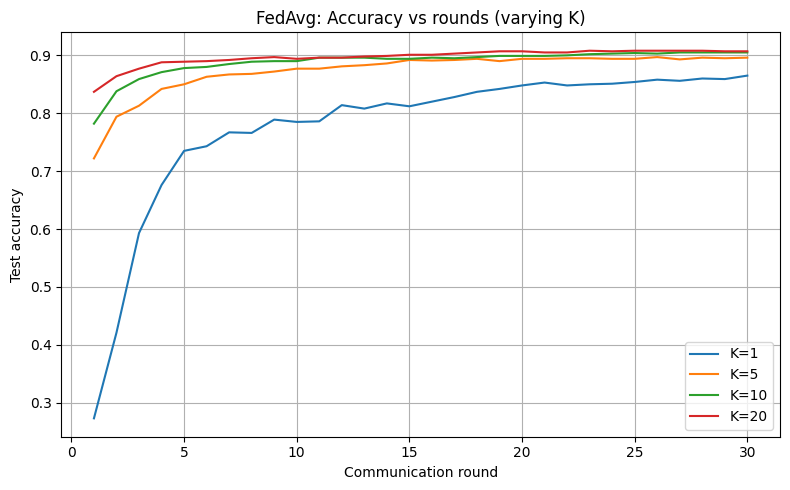

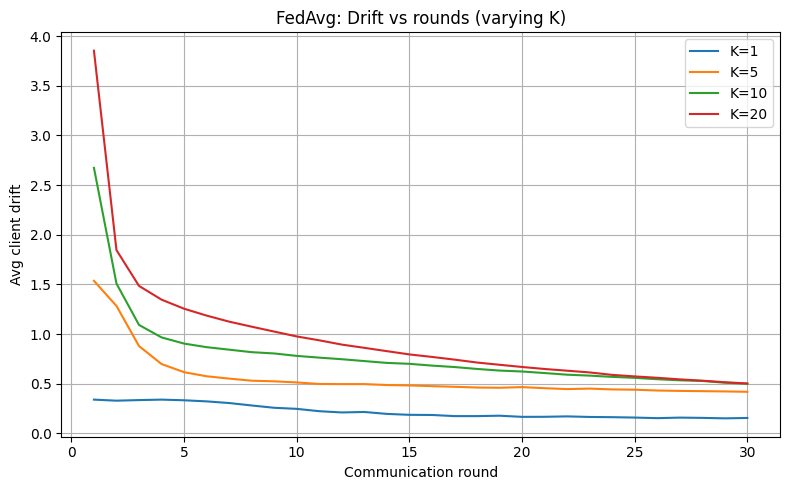

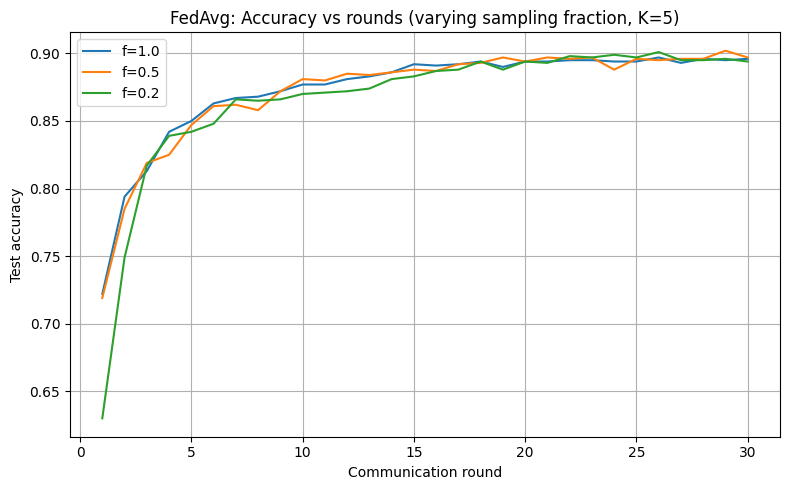

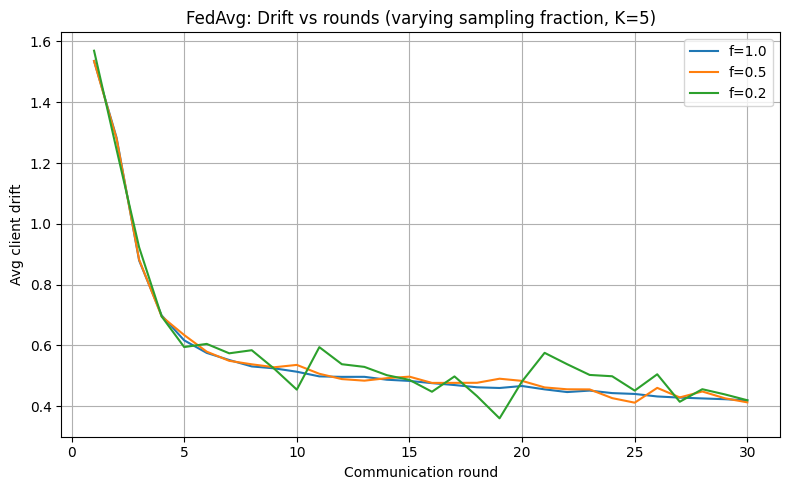


Final results (varying K):
K=1: final acc=0.8650, final drift=0.1552
K=5: final acc=0.8960, final drift=0.4187
K=10: final acc=0.9050, final drift=0.5000
K=20: final acc=0.9070, final drift=0.5024

Final results (varying sampling fraction, K=5):
f=1.0: final acc=0.8960, final drift=0.4187
f=0.5: final acc=0.8970, final drift=0.4121
f=0.2: final acc=0.8940, final drift=0.4191
\nSaved plots: fedavg_acc_vs_K.png, fedavg_drift_vs_K.png, fedavg_acc_vs_sampling.png, fedavg_drift_vs_sampling.png


In [ ]:
# fedavg_mnist_experiments.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import os

# -----------------------
# Settings
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu")   # change to "cuda" if you want GPU
num_clients = 10
total_train = 3000      # total training examples (small for quick experiments)
total_val = 500
total_test = 1000
assert total_train % num_clients == 0
per_client = total_train // num_clients

batch_size_local = 32
rounds = 30
lr = 0.05

# -----------------------
# Tiny MLP (same as Task 1)
class TinyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -----------------------
# Load MNIST (try torchvision; if not available, synthetic fallback)
transform = transforms.Compose([transforms.ToTensor()])

use_synth = False
try:
    mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    mnist_test  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    # sample a small subset randomly for speed and reproducibility
    all_idx = list(range(len(mnist_train)))
    random.shuffle(all_idx)
    selected = all_idx[: total_train + total_val]
    train_idx = selected[:total_train]
    val_idx = selected[total_train: total_train + total_val]

    train_data = Subset(mnist_train, train_idx)
    val_data = Subset(mnist_train, val_idx)

    # split train_data into equal IID client subsets
    train_indices_in_subset = train_idx  # global indices
    client_subsets = []
    for i in range(num_clients):
        chunk = train_indices_in_subset[i*per_client:(i+1)*per_client]
        client_subsets.append(Subset(mnist_train, chunk))

    # test subset
    if total_test <= len(mnist_test):
        test_subset = Subset(mnist_test, list(range(total_test)))
    else:
        test_subset = mnist_test

except Exception as e:
    print("Warning: torchvision MNIST unavailable or failed. Falling back to synthetic MNIST-like data.")
    use_synth = True
    # synthetic MNIST-like (28x28 grayscale)
    def make_synth(n):
        dim = 28*28
        centers = np.random.randn(10, dim) * 2.0
        X = np.zeros((n, 1, 28, 28), dtype=np.float32)
        y = np.zeros(n, dtype=np.int64)
        for i in range(n):
            lbl = i % 10
            vec = centers[lbl] + 0.8 * np.random.randn(dim)
            X[i,0] = vec.reshape(28,28)
            y[i] = lbl
        idx = np.arange(n); np.random.shuffle(idx)
        return X[idx], y[idx]
    Xall, yall = make_synth(total_train + total_val + total_test)
    Xtr = torch.tensor(Xall[:total_train])
    ytr = torch.tensor(yall[:total_train])
    Xval = torch.tensor(Xall[total_train: total_train+total_val])
    yval = torch.tensor(yall[total_train: total_train+total_val])
    Xtest = torch.tensor(Xall[total_train+total_val: total_train+total_val+total_test])
    ytest = torch.tensor(yall[total_train+total_val: total_train+total_val+total_test])

    client_subsets = []
    for i in range(num_clients):
        s = slice(i*per_client, (i+1)*per_client)
        client_subsets.append(TensorDataset(Xtr[s], ytr[s]))
    val_data = TensorDataset(Xval, yval)
    test_subset = TensorDataset(Xtest, ytest)

# -----------------------
# Data loaders helpers
from torch.utils.data import DataLoader
def get_client_loader(i, batch_size=batch_size_local, shuffle=True):
    return DataLoader(client_subsets[i], batch_size=batch_size, shuffle=shuffle)

test_loader = DataLoader(test_subset, batch_size=256, shuffle=False)
val_loader = DataLoader(val_data, batch_size=256, shuffle=False)

# -----------------------
criterion = nn.CrossEntropyLoss()

def evaluate(model, loader):
    model.eval()
    total=0; correct=0; loss_sum=0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss_sum += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return loss_sum/total, correct/total

def param_vector(model):
    return torch.cat([p.data.view(-1).clone() for p in model.parameters()])

def model_distance(m1, m2):
    v1, v2 = param_vector(m1), param_vector(m2)
    return torch.norm(v1 - v2).item()

# -----------------------
def fedavg_run(K=1, rounds=30, sampling_fraction=1.0, lr_local=0.05, local_batch=32):
    # deterministic global init
    torch.manual_seed(0)
    global_model = TinyMLP().to(device)
    for p in global_model.parameters():
        p.data.uniform_(-0.1, 0.1)
    accs=[]; losses=[]; avg_drifts=[]; comms=[]
    num_sample = lambda: max(1, int(round(sampling_fraction * num_clients)))
    for r in range(rounds):
        n = num_sample()
        sampled = sorted(random.sample(range(num_clients), n))
        comms.append(n)
        client_models=[]; drift_vals=[]
        for i in sampled:
            local_model = deepcopy(global_model)
            local_model.train()
            opt = optim.SGD(local_model.parameters(), lr=lr_local)
            loader = get_client_loader(i, batch_size=local_batch, shuffle=True)
            for ep in range(K):
                for xb, yb in loader:
                    xb, yb = xb.to(device), yb.to(device)
                    opt.zero_grad()
                    logits = local_model(xb)
                    loss = criterion(logits, yb)
                    loss.backward()
                    opt.step()
            client_models.append(local_model)
            drift_vals.append(model_distance(local_model, global_model))
        # aggregate (equal-weight average)
        new_global = deepcopy(global_model)
        for p in new_global.parameters(): p.data.zero_()
        for lm in client_models:
            for p_new, p_local in zip(new_global.parameters(), lm.parameters()):
                p_new.data.add_(p_local.data)
        for p in new_global.parameters(): p.data.div_(len(client_models))
        global_model = new_global
        gloss, gacc = evaluate(global_model, test_loader)
        accs.append(gacc); losses.append(gloss); avg_drifts.append(float(np.mean(drift_vals)))
    return {"accs": accs, "losses": losses, "drifts": avg_drifts, "comms": comms}

# -----------------------
# Experiments
Ks = [1, 5, 10, 20]
results_K = {}
for K in Ks:
    print("Running K=", K)
    results_K[K] = fedavg_run(K=K, rounds=rounds, sampling_fraction=1.0, lr_local=lr, local_batch=batch_size_local)

sampling_fracs = [1.0, 0.5, 0.2]
results_f = {}
for f in sampling_fracs:
    print("Running sampling f=", f, "with K=5")
    results_f[f] = fedavg_run(K=5, rounds=rounds, sampling_fraction=f, lr_local=lr, local_batch=batch_size_local)

# -----------------------
# Plotting (matplotlib)
plt.figure(figsize=(8,5))
for K in Ks:
    plt.plot(range(1, rounds+1), results_K[K]["accs"], label=f"K={K}")
plt.xlabel("Communication round"); plt.ylabel("Test accuracy"); plt.title("FedAvg: Accuracy vs rounds (varying K)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("fedavg_acc_vs_K.png")
plt.show()

plt.figure(figsize=(8,5))
for K in Ks:
    plt.plot(range(1, rounds+1), results_K[K]["drifts"], label=f"K={K}")
plt.xlabel("Communication round"); plt.ylabel("Avg client drift"); plt.title("FedAvg: Drift vs rounds (varying K)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("fedavg_drift_vs_K.png")
plt.show()

plt.figure(figsize=(8,5))
for f in sampling_fracs:
    plt.plot(range(1, rounds+1), results_f[f]["accs"], label=f"f={f}")
plt.xlabel("Communication round"); plt.ylabel("Test accuracy"); plt.title("FedAvg: Accuracy vs rounds (varying sampling fraction, K=5)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("fedavg_acc_vs_sampling.png")
plt.show()

plt.figure(figsize=(8,5))
for f in sampling_fracs:
    plt.plot(range(1, rounds+1), results_f[f]["drifts"], label=f"f={f}")
plt.xlabel("Communication round"); plt.ylabel("Avg client drift"); plt.title("FedAvg: Drift vs rounds (varying sampling fraction, K=5)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("fedavg_drift_vs_sampling.png")
plt.show()

# Print short summary
print("\nFinal results (varying K):")
for K in Ks:
    print(f"K={K}: final acc={results_K[K]['accs'][-1]:.4f}, final drift={results_K[K]['drifts'][-1]:.4f}")
print("\nFinal results (varying sampling fraction, K=5):")
for f in sampling_fracs:
    print(f"f={f}: final acc={results_f[f]['accs'][-1]:.4f}, final drift={results_f[f]['drifts'][-1]:.4f}")

print('\\nSaved plots: fedavg_acc_vs_K.png, fedavg_drift_vs_K.png, fedavg_acc_vs_sampling.png, fedavg_drift_vs_sampling.png')


# Task 3

MNIST loaded via torchvision. Using real MNIST subset.

=== alpha = 0.05 ===

Per-client sample counts: [906, 1649, 400, 864, 1181]
Round 001 | test_acc=0.3278 | test_loss=1.9438 | avg_drift=1.3351
Round 002 | test_acc=0.4765 | test_loss=1.6436 | avg_drift=1.1255
Round 003 | test_acc=0.5660 | test_loss=1.4128 | avg_drift=0.9555
Round 004 | test_acc=0.6396 | test_loss=1.2388 | avg_drift=0.8358
Round 005 | test_acc=0.6674 | test_loss=1.1188 | avg_drift=0.7489
Round 006 | test_acc=0.6919 | test_loss=1.0253 | avg_drift=0.6893
Round 007 | test_acc=0.7067 | test_loss=0.9502 | avg_drift=0.6462
Round 008 | test_acc=0.7213 | test_loss=0.8931 | avg_drift=0.6128
Round 009 | test_acc=0.7336 | test_loss=0.8460 | avg_drift=0.5863
Round 010 | test_acc=0.7436 | test_loss=0.8106 | avg_drift=0.5648
Round 011 | test_acc=0.7548 | test_loss=0.7785 | avg_drift=0.5471
Round 012 | test_acc=0.7642 | test_loss=0.7508 | avg_drift=0.5309
Round 013 | test_acc=0.7768 | test_loss=0.7207 | avg_drift=0.5185
Round 014 

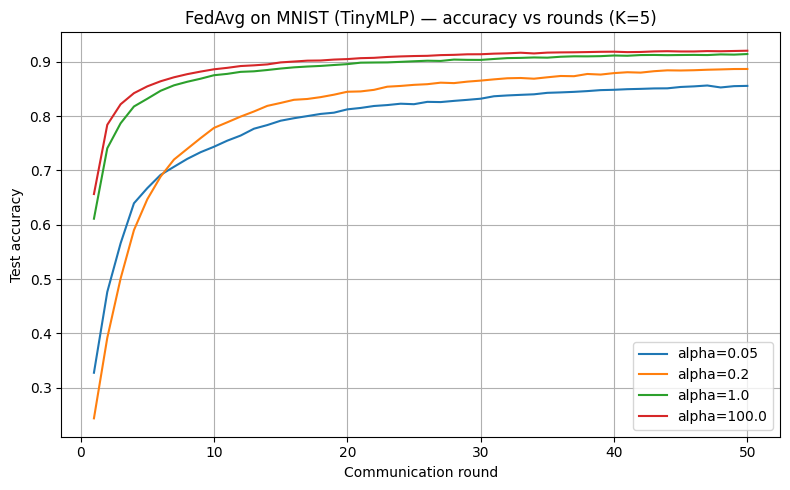

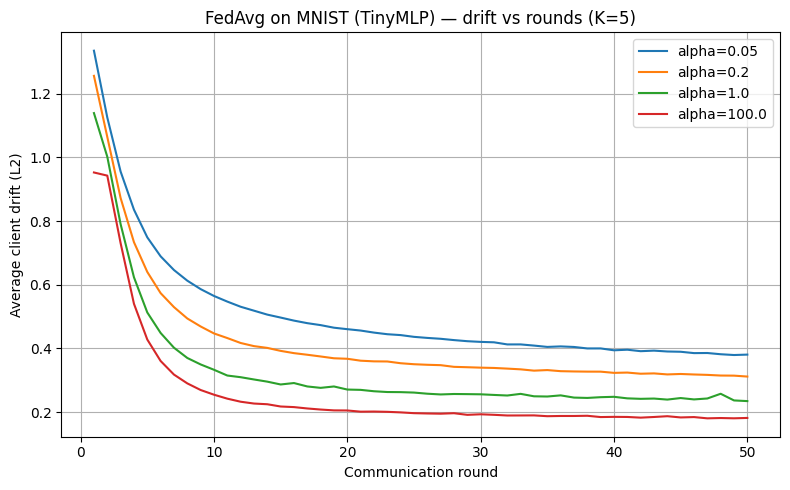


Final summary after 50 rounds:
alpha=0.05: final_acc=0.8556, final_drift=0.3805
alpha=0.2: final_acc=0.8867, final_drift=0.3116
alpha=1.0: final_acc=0.9142, final_drift=0.2345
alpha=100.0: final_acc=0.9203, final_drift=0.1816

Plots saved in: fedavg_dirichlet_outputs


In [ ]:
# fedavg_dirichlet_mnist_tinymlp.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np, random, matplotlib.pyplot as plt
from torchvision import datasets, transforms
from copy import deepcopy
import os

# -----------------------
# Config & reproducibility
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu")   # set "cuda" if you have GPU and want faster runs

# Federated experiment settings (edit as needed)
num_clients = 5           # M
K_local = 5               # local epochs per round (fixed)
rounds = 50               # communication rounds
local_lr = 0.01
local_batch = 32

# Data settings
use_total_train = 5000    # total training examples to use (subset of MNIST for speed)
test_batch = 256

# Dirichlet alphas to evaluate
alpha_list = [0.05, 0.2, 1.0, 100.0]

# Minimum client size guard (to avoid empty clients for extreme alphas)
min_size_per_client = 5

# Output folder for plots
out_dir = "fedavg_dirichlet_outputs"
os.makedirs(out_dir, exist_ok=True)

# -----------------------
# TinyMLP (Option A)
class TinyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -----------------------
# Load MNIST (fallback to synthetic if torchvision fails)
transform = transforms.Compose([transforms.ToTensor()])
use_synthetic = False
try:
    mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    mnist_test  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    # pick a reproducible subset for speed
    all_indices = list(range(len(mnist_train)))
    random.shuffle(all_indices)
    sel = all_indices[: use_total_train]  # indices into mnist_train
    subset_train = Subset(mnist_train, sel)
    # build class->local-index mapping relative to subset_train
    labels = np.array([mnist_train[i][1] for i in sel])
    class_indices = {c: list(np.where(labels == c)[0]) for c in range(10)}
    print("MNIST loaded via torchvision. Using real MNIST subset.")
except Exception as e:
    print("Warning: torchvision MNIST unavailable (or failed). Falling back to synthetic MNIST-like data.")
    use_synthetic = True
    def make_synth_mnist(n):
        dim = 28*28
        centers = np.random.randn(10, dim) * 2.0
        X = np.zeros((n, 1, 28, 28), dtype=np.float32)
        y = np.zeros(n, dtype=np.int64)
        for i in range(n):
            lbl = i % 10
            vec = centers[lbl] + 0.8 * np.random.randn(dim)
            X[i,0] = vec.reshape(28,28)
            y[i] = lbl
        idx = np.arange(n); np.random.shuffle(idx)
        return X[idx], y[idx]
    Xall, yall = make_synth_mnist(use_total_train + 1000)
    Xtr = torch.tensor(Xall[:use_total_train])
    ytr = torch.tensor(yall[:use_total_train])
    subset_train = TensorDataset(Xtr, ytr)
    # build class_indices relative to subset
    labels = ytr.numpy()
    class_indices = {c: list(np.where(labels == c)[0]) for c in range(10)}
    # synthetic test
    Xtest = torch.tensor(Xall[use_total_train: use_total_train + 1000])
    ytest = torch.tensor(yall[use_total_train: use_total_train + 1000])
    mnist_test = TensorDataset(Xtest, ytest)

test_loader = DataLoader(mnist_test, batch_size=test_batch, shuffle=False)
criterion = nn.CrossEntropyLoss()

# -----------------------
# Dirichlet partition function
def dirichlet_partition(indices_by_class, n_clients, alpha, min_size=0):
    """Partition indices_by_class (dict[class]->list of indices relative to subset)
       into n_clients lists using Dirichlet(alpha). Returns list of lists (per-client indices).
    """
    client_indices = [[] for _ in range(n_clients)]
    for c, idxs in indices_by_class.items():
        if len(idxs) == 0:
            continue
        # draw probabilities for this class across clients
        probs = np.random.default_rng().dirichlet([alpha] * n_clients)
        # counts per client
        counts = (probs * len(idxs)).astype(int)
        # fix rounding so counts sum to len(idxs)
        while counts.sum() < len(idxs):
            counts[np.argmin(counts)] += 1
        while counts.sum() > len(idxs):
            counts[np.argmax(counts)] -= 1
        # shuffle indices and split
        idxs_shuf = idxs.copy()
        random.shuffle(idxs_shuf)
        ptr = 0
        for i in range(n_clients):
            take = counts[i]
            if take > 0:
                client_indices[i].extend(idxs_shuf[ptr:ptr+take])
            ptr += take
    # enforce min sizes by stealing from largest if needed
    for i in range(n_clients):
        if len(client_indices[i]) < min_size:
            # find largest
            sizes = [len(client_indices[j]) for j in range(n_clients)]
            largest = int(np.argmax(sizes))
            needed = min_size - len(client_indices[i])
            moved = client_indices[largest][:needed]
            client_indices[i].extend(moved)
            client_indices[largest] = client_indices[largest][needed:]
    return client_indices

# Create client Subset objects from relative indices
from torch.utils.data import Subset
def make_client_subsets(subset_dataset, client_idx_lists):
    client_subsets = []
    for idx_list in client_idx_lists:
        client_subsets.append(Subset(subset_dataset, idx_list))
    return client_subsets

# -----------------------
# Utility functions
def flatten_params(model):
    return torch.cat([p.detach().cpu().view(-1) for p in model.parameters()])

def param_l2_distance(m1, m2):
    v1 = flatten_params(m1)
    v2 = flatten_params(m2)
    return torch.norm(v1 - v2).item()

def evaluate_model(model, loader, device=device):
    model.eval()
    total = 0; correct = 0; loss_sum = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss_sum += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return loss_sum/total, correct/total

# -----------------------
# FedAvg run on given client_subsets (full participation)
def run_fedavg(client_subsets, K=K_local, rounds=rounds, lr=local_lr, batch=local_batch, device=device):
    # deterministic init
    torch.manual_seed(0)
    global_model = TinyMLP().to(device)
    for p in global_model.parameters():
        p.data.uniform_(-0.1, 0.1)
    n_clients = len(client_subsets)
    client_loaders = [DataLoader(s, batch_size=batch, shuffle=True) for s in client_subsets]
    accs = []
    losses = []
    avg_drifts = []
    counts = np.array([len(s) for s in client_subsets], dtype=float)
    for r in range(1, rounds + 1):
        client_models = []
        drifts = []
        for i in range(n_clients):
            local_model = deepcopy(global_model).to(device)
            local_model.train()
            opt = optim.SGD(local_model.parameters(), lr=lr)
            for ep in range(K):
                for xb, yb in client_loaders[i]:
                    xb, yb = xb.to(device), yb.to(device)
                    opt.zero_grad()
                    logits = local_model(xb)
                    loss = criterion(logits, yb)
                    loss.backward()
                    opt.step()
            client_models.append(local_model)
            drifts.append(param_l2_distance(local_model, global_model))
        # aggregate weighted by client data size
        new_global = deepcopy(global_model)
        for p in new_global.parameters(): p.data.zero_()
        wsum = counts.sum()
        for i, lm in enumerate(client_models):
            w = counts[i] / wsum
            for p_new, p_local in zip(new_global.parameters(), lm.parameters()):
                p_new.data.add_(p_local.data * w)
        global_model = new_global
        # evaluate
        loss_val, acc_val = evaluate_model(global_model, test_loader, device=device)
        accs.append(acc_val)
        losses.append(loss_val)
        avg_drifts.append(float(np.mean(drifts)))
        print(f"Round {r:03d} | test_acc={acc_val:.4f} | test_loss={loss_val:.4f} | avg_drift={avg_drifts[-1]:.4f}")
    return {"model": global_model, "accs": accs, "losses": losses, "drifts": avg_drifts, "sizes": counts}

# -----------------------
# Main experiment over alphas
all_results = {}
for alpha in alpha_list:
    print("\n=== alpha =", alpha, "===\n")
    # reseed for reproducible partitioning
    np.random.seed(seed); random.seed(seed)
    client_idx_lists = dirichlet_partition(class_indices, num_clients, alpha, min_size=min_size_per_client)
    client_subsets = make_client_subsets(subset_train, client_idx_lists)
    sizes = [len(s) for s in client_subsets]
    print("Per-client sample counts:", sizes)
    # sanity check: ensure none is empty
    if any([len(s) == 0 for s in client_subsets]):
        print("Warning: a client has 0 samples — consider increasing total_train_use or min_size_per_client.")
    res = run_fedavg(client_subsets, K=K_local, rounds=rounds, lr=local_lr, batch=local_batch, device=device)
    all_results[alpha] = res

# -----------------------
# Plot accuracy vs rounds
plt.figure(figsize=(8,5))
for alpha in alpha_list:
    plt.plot(range(1, rounds+1), all_results[alpha]["accs"], label=f"alpha={alpha}")
plt.xlabel("Communication round")
plt.ylabel("Test accuracy")
plt.title(f"FedAvg on MNIST (TinyMLP) — accuracy vs rounds (K={K_local})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "accuracy_vs_alpha.png"), dpi=150)
plt.show()

# Plot drift vs rounds
plt.figure(figsize=(8,5))
for alpha in alpha_list:
    plt.plot(range(1, rounds+1), all_results[alpha]["drifts"], label=f"alpha={alpha}")
plt.xlabel("Communication round")
plt.ylabel("Average client drift (L2)")
plt.title(f"FedAvg on MNIST (TinyMLP) — drift vs rounds (K={K_local})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "drift_vs_alpha.png"), dpi=150)
plt.show()

# Summary
print("\nFinal summary after", rounds, "rounds:")
for alpha in alpha_list:
    print(f"alpha={alpha}: final_acc={all_results[alpha]['accs'][-1]:.4f}, final_drift={all_results[alpha]['drifts'][-1]:.4f}")

print("\nPlots saved in:", out_dir)


# Task 4.1

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.62MB/s]


Using torchvision MNIST (subset).

Running experiments for alpha = 0.05

Client sizes: [1783, 188, 37, 2044, 948]

-- Running mu = 0.0 --
[mu=0.0000] Round 001 | test_acc=0.3464 | test_loss=1.8085 | avg_drift=1.2104
[mu=0.0000] Round 002 | test_acc=0.5547 | test_loss=1.4411 | avg_drift=0.9651
[mu=0.0000] Round 003 | test_acc=0.6706 | test_loss=1.1594 | avg_drift=0.7858
[mu=0.0000] Round 004 | test_acc=0.7107 | test_loss=0.9902 | avg_drift=0.6629
[mu=0.0000] Round 005 | test_acc=0.7399 | test_loss=0.8720 | avg_drift=0.5869
[mu=0.0000] Round 006 | test_acc=0.7599 | test_loss=0.7850 | avg_drift=0.5400
[mu=0.0000] Round 007 | test_acc=0.7677 | test_loss=0.7329 | avg_drift=0.5042
[mu=0.0000] Round 008 | test_acc=0.7799 | test_loss=0.6842 | avg_drift=0.4745
[mu=0.0000] Round 009 | test_acc=0.7891 | test_loss=0.6456 | avg_drift=0.4598
[mu=0.0000] Round 010 | test_acc=0.7972 | test_loss=0.6168 | avg_drift=0.4399
[mu=0.0000] Round 011 | test_acc=0.8035 | test_loss=0.5916 | avg_drift=0.4248
[mu=

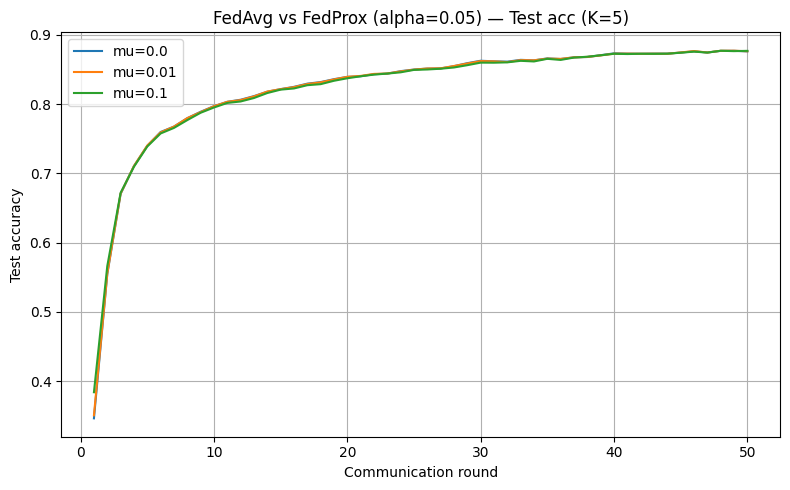

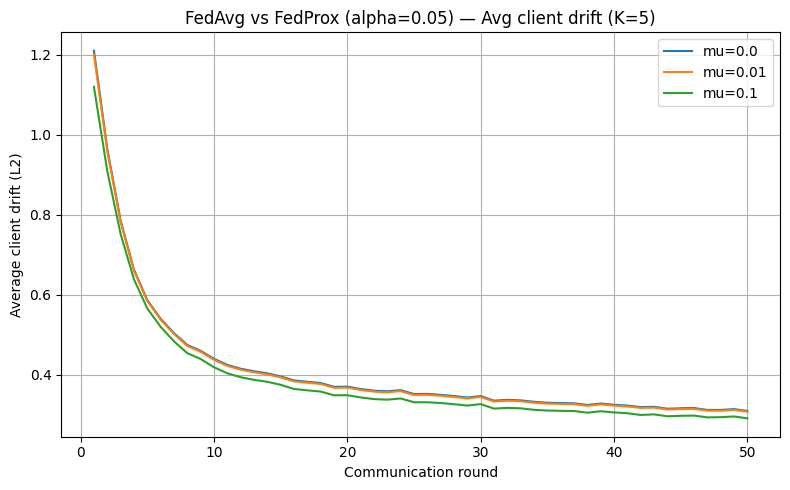


Running experiments for alpha = 0.2

Client sizes: [1349, 1072, 580, 205, 1794]

-- Running mu = 0.0 --
[mu=0.0000] Round 001 | test_acc=0.3973 | test_loss=1.8010 | avg_drift=1.2868
[mu=0.0000] Round 002 | test_acc=0.5800 | test_loss=1.3930 | avg_drift=1.0691
[mu=0.0000] Round 003 | test_acc=0.6743 | test_loss=1.1102 | avg_drift=0.8555
[mu=0.0000] Round 004 | test_acc=0.7298 | test_loss=0.9247 | avg_drift=0.7123
[mu=0.0000] Round 005 | test_acc=0.7524 | test_loss=0.8171 | avg_drift=0.6204
[mu=0.0000] Round 006 | test_acc=0.7743 | test_loss=0.7401 | avg_drift=0.5561
[mu=0.0000] Round 007 | test_acc=0.7930 | test_loss=0.6767 | avg_drift=0.5173
[mu=0.0000] Round 008 | test_acc=0.8102 | test_loss=0.6295 | avg_drift=0.4855
[mu=0.0000] Round 009 | test_acc=0.8216 | test_loss=0.5926 | avg_drift=0.4629
[mu=0.0000] Round 010 | test_acc=0.8280 | test_loss=0.5692 | avg_drift=0.4456
[mu=0.0000] Round 011 | test_acc=0.8332 | test_loss=0.5480 | avg_drift=0.4282
[mu=0.0000] Round 012 | test_acc=0.84

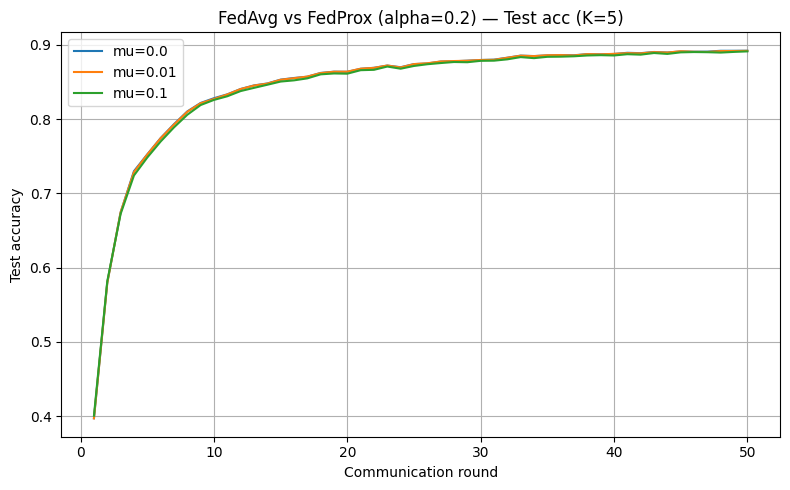

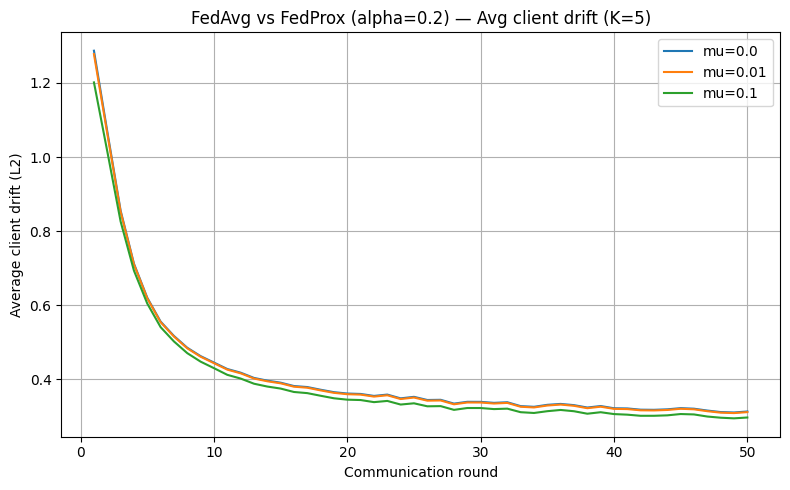


Running experiments for alpha = 1.0

Client sizes: [885, 1323, 1048, 658, 1086]

-- Running mu = 0.0 --
[mu=0.0000] Round 001 | test_acc=0.5906 | test_loss=1.7394 | avg_drift=1.1335
[mu=0.0000] Round 002 | test_acc=0.7594 | test_loss=1.2262 | avg_drift=1.0000
[mu=0.0000] Round 003 | test_acc=0.8152 | test_loss=0.9038 | avg_drift=0.7688
[mu=0.0000] Round 004 | test_acc=0.8395 | test_loss=0.7288 | avg_drift=0.5884
[mu=0.0000] Round 005 | test_acc=0.8525 | test_loss=0.6277 | avg_drift=0.4793
[mu=0.0000] Round 006 | test_acc=0.8624 | test_loss=0.5617 | avg_drift=0.4127
[mu=0.0000] Round 007 | test_acc=0.8717 | test_loss=0.5162 | avg_drift=0.3703
[mu=0.0000] Round 008 | test_acc=0.8758 | test_loss=0.4833 | avg_drift=0.3404
[mu=0.0000] Round 009 | test_acc=0.8798 | test_loss=0.4570 | avg_drift=0.3204
[mu=0.0000] Round 010 | test_acc=0.8844 | test_loss=0.4370 | avg_drift=0.3042
[mu=0.0000] Round 011 | test_acc=0.8875 | test_loss=0.4208 | avg_drift=0.2922
[mu=0.0000] Round 012 | test_acc=0.89

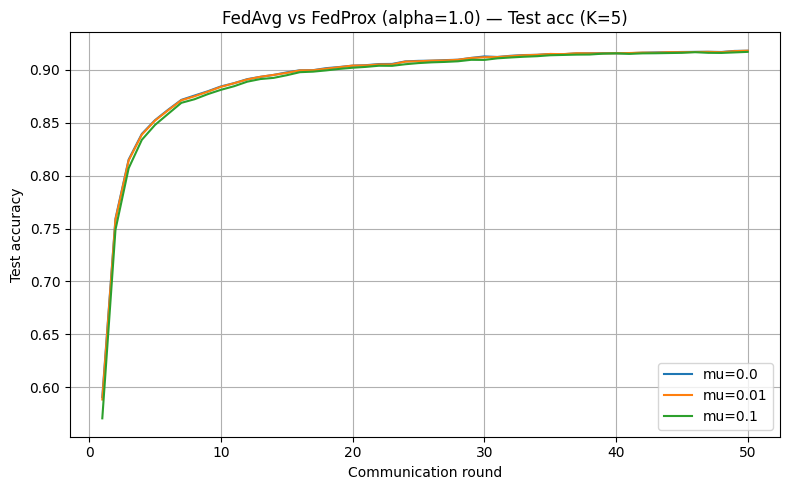

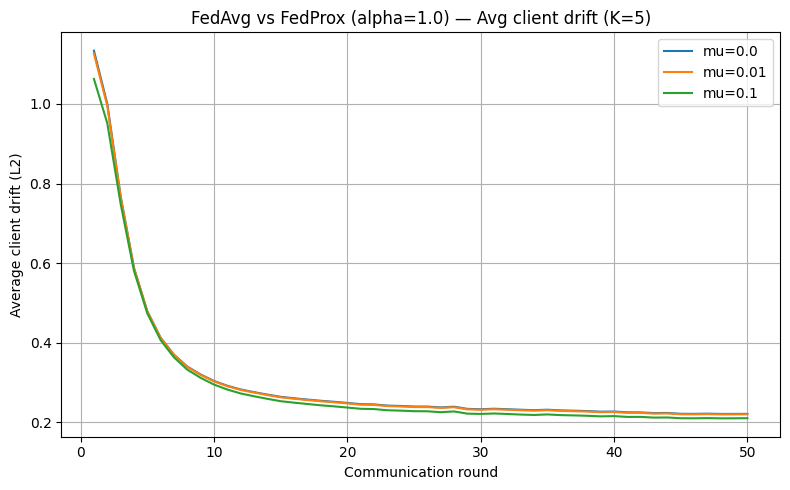


Running experiments for alpha = 100.0

Client sizes: [980, 1064, 1036, 960, 960]

-- Running mu = 0.0 --
[mu=0.0000] Round 001 | test_acc=0.6535 | test_loss=1.7239 | avg_drift=0.9459
[mu=0.0000] Round 002 | test_acc=0.7845 | test_loss=1.1791 | avg_drift=0.9361
[mu=0.0000] Round 003 | test_acc=0.8215 | test_loss=0.8590 | avg_drift=0.7291
[mu=0.0000] Round 004 | test_acc=0.8408 | test_loss=0.6931 | avg_drift=0.5398
[mu=0.0000] Round 005 | test_acc=0.8554 | test_loss=0.5984 | avg_drift=0.4269
[mu=0.0000] Round 006 | test_acc=0.8641 | test_loss=0.5388 | avg_drift=0.3586
[mu=0.0000] Round 007 | test_acc=0.8726 | test_loss=0.4957 | avg_drift=0.3160
[mu=0.0000] Round 008 | test_acc=0.8773 | test_loss=0.4658 | avg_drift=0.2868
[mu=0.0000] Round 009 | test_acc=0.8819 | test_loss=0.4416 | avg_drift=0.2661
[mu=0.0000] Round 010 | test_acc=0.8860 | test_loss=0.4235 | avg_drift=0.2506
[mu=0.0000] Round 011 | test_acc=0.8900 | test_loss=0.4081 | avg_drift=0.2402
[mu=0.0000] Round 012 | test_acc=0.8

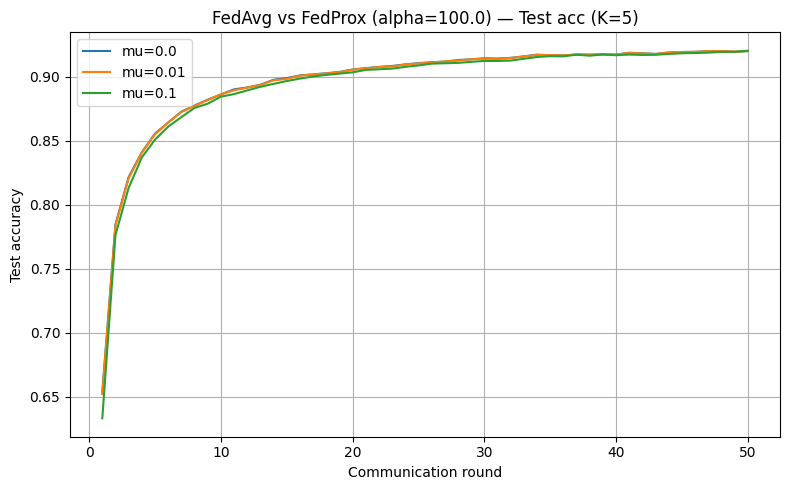

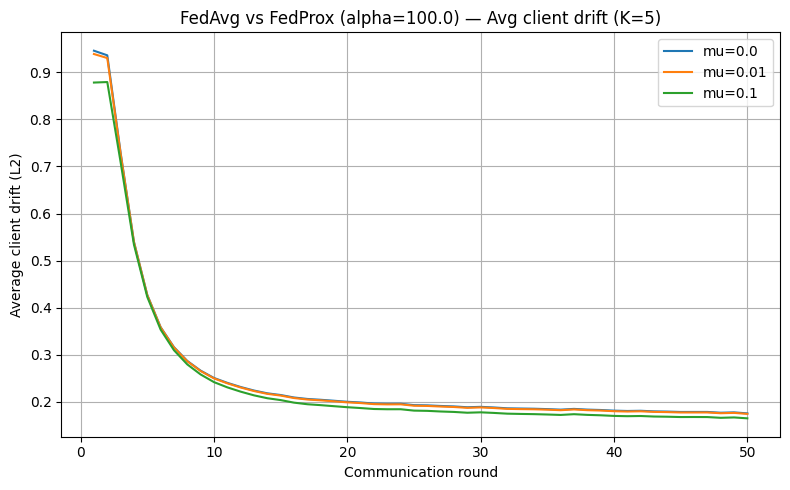



=== FINAL SUMMARY ===
alpha=  0.05 mu=  0.0 -> final_acc=0.8763, final_drift=0.3096
alpha=  0.05 mu= 0.01 -> final_acc=0.8765, final_drift=0.3076
alpha=  0.05 mu=  0.1 -> final_acc=0.8771, final_drift=0.2910
alpha=   0.2 mu=  0.0 -> final_acc=0.8919, final_drift=0.3136
alpha=   0.2 mu= 0.01 -> final_acc=0.8917, final_drift=0.3119
alpha=   0.2 mu=  0.1 -> final_acc=0.8910, final_drift=0.2974
alpha=   1.0 mu=  0.0 -> final_acc=0.9182, final_drift=0.2215
alpha=   1.0 mu= 0.01 -> final_acc=0.9182, final_drift=0.2204
alpha=   1.0 mu=  0.1 -> final_acc=0.9171, final_drift=0.2107
alpha= 100.0 mu=  0.0 -> final_acc=0.9199, final_drift=0.1753
alpha= 100.0 mu= 0.01 -> final_acc=0.9199, final_drift=0.1742
alpha= 100.0 mu=  0.1 -> final_acc=0.9202, final_drift=0.1648

Plots and results saved in fedprox_outputs


In [ ]:
# fedprox_vs_fedavg_mnist_tinymlp.py
# Compare FedAvg and FedProx (proximal term) on MNIST with Dirichlet label skew partitions
# Uses TinyMLP (784 -> 128 -> 10) as requested.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms

# -------------------------
# Configuration (editable)
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu")  # change to "cuda" if you want GPU

num_clients = 5               # M
K_local = 5                   # local epochs
rounds = 50                   # communication rounds
local_lr = 0.01
local_batch = 32

use_total_train = 5000        # subset of MNIST for speed
test_batch = 256

alpha_list = [0.05, 0.2, 1.0, 100.0]  # Dirichlet alphas to try
mu_list = [0.0, 0.01, 0.1]            # mu=0.0 -> FedAvg baseline; others are FedProx
# We'll run FedAvg (mu=0) and one or more FedProx mu values and compare.

min_size_per_client = 5
out_dir = "fedprox_outputs"
os.makedirs(out_dir, exist_ok=True)

# -------------------------
# Model: TinyMLP (Option A)
class TinyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -------------------------
# Load MNIST (falls back to synthetic if torchvision fails)
transform = transforms.Compose([transforms.ToTensor()])
use_synth = False
try:
    mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    mnist_test  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    # select a random subset of train for speed
    all_idx = list(range(len(mnist_train)))
    random.shuffle(all_idx)
    sel = all_idx[:use_total_train]
    subset_train = Subset(mnist_train, sel)
    # create mapping class -> indices relative to subset
    labels = np.array([mnist_train[i][1] for i in sel])
    class_indices = {c: list(np.where(labels == c)[0]) for c in range(10)}
    print("Using torchvision MNIST (subset).")
except Exception as e:
    print("Warning: torchvision MNIST unavailable, using synthetic MNIST-like data. Error:", e)
    use_synth = True
    def make_synth_mnist(n):
        dim = 28*28
        centers = np.random.randn(10, dim) * 2.0
        X = np.zeros((n, 1, 28, 28), dtype=np.float32)
        y = np.zeros(n, dtype=np.int64)
        for i in range(n):
            lbl = i % 10
            vec = centers[lbl] + 0.8 * np.random.randn(dim)
            X[i,0] = vec.reshape(28,28)
            y[i] = lbl
        idx = np.arange(n); np.random.shuffle(idx)
        return X[idx], y[idx]
    Xall, yall = make_synth_mnist(use_total_train + 1000)
    Xtr = torch.tensor(Xall[:use_total_train])
    ytr = torch.tensor(yall[:use_total_train])
    subset_train = TensorDataset(Xtr, ytr)
    labels = ytr.numpy()
    class_indices = {c: list(np.where(labels == c)[0]) for c in range(10)}
    Xtest = torch.tensor(Xall[use_total_train:use_total_train+1000])
    ytest = torch.tensor(yall[use_total_train:use_total_train+1000])
    mnist_test = TensorDataset(Xtest, ytest)

test_loader = DataLoader(mnist_test, batch_size=test_batch, shuffle=False)
criterion = nn.CrossEntropyLoss()

# -------------------------
# Dirichlet partition function (returns list of per-client relative indices)
def dirichlet_partition(indices_by_class, n_clients, alpha, min_size=0):
    client_indices = [[] for _ in range(n_clients)]
    rng = np.random.default_rng(seed)  # reproducible for class draws
    for c, idxs in indices_by_class.items():
        if len(idxs) == 0:
            continue
        probs = rng.dirichlet([alpha] * n_clients)
        counts = (probs * len(idxs)).astype(int)
        # fix rounding
        while counts.sum() < len(idxs):
            counts[np.argmin(counts)] += 1
        while counts.sum() > len(idxs):
            counts[np.argmax(counts)] -= 1
        idxs_shuf = idxs.copy()
        random.shuffle(idxs_shuf)
        ptr = 0
        for i in range(n_clients):
            take = counts[i]
            if take > 0:
                client_indices[i].extend(idxs_shuf[ptr:ptr+take])
            ptr += take
    # enforce minimum sizes if requested
    for i in range(n_clients):
        if len(client_indices[i]) < min_size:
            sizes = [len(client_indices[j]) for j in range(n_clients)]
            largest = int(np.argmax(sizes))
            needed = min_size - len(client_indices[i])
            moved = client_indices[largest][:needed]
            client_indices[i].extend(moved)
            client_indices[largest] = client_indices[largest][needed:]
    return client_indices

# helper to build Subset objects for clients
from torch.utils.data import Subset
def make_client_subsets(subset_dataset, client_idx_lists):
    return [Subset(subset_dataset, li) for li in client_idx_lists]

# -------------------------
# Flatten parameters / param distance utilities
def flatten_params(model):
    return torch.cat([p.detach().cpu().view(-1) for p in model.parameters()])

def param_l2_distance(m1, m2):
    v1 = flatten_params(m1); v2 = flatten_params(m2)
    return torch.norm(v1 - v2).item()

# -------------------------
# Local training step: with FedProx proximal term
def local_train_prox(local_model, global_model_params, dataloader, K, lr, mu, device):
    """Train local_model on dataloader for K epochs with SGD and proximal term mu
       global_model_params: list of tensors (same structure as model.parameters()) representing theta_global
    """
    local_model.train()
    opt = optim.SGD(local_model.parameters(), lr=lr)
    # Precompute flattened theta_global for manual proximal? We'll compute prox via parameter-wise difference.
    for epoch in range(K):
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = local_model(xb)
            loss = criterion(logits, yb)
            if mu > 0.0:
                # add proximal term: (mu/2) * ||theta_local - theta_global||^2
                sq = 0.0
                # sum parameter-wise squared diffs
                for p_local, p_global in zip(local_model.parameters(), global_model_params):
                    # p_global is CPU; bring to device to compute with p_local
                    pg = p_global.to(p_local.device)
                    sq = sq + torch.sum((p_local - pg) ** 2)
                prox = (mu / 2.0) * sq
                loss = loss + prox
            loss.backward()
            opt.step()
    return local_model

# A helper using autodiff: equivalent approach but slightly more efficient to compute prox outside loop isn't necessary.
# We'll pass global_model parameters as CPU tensors (detached) to avoid accidental autograd tracking.

# -------------------------
# Fed training runner that supports mu (mu=0 => FedAvg)
def run_fed_algorithm(client_subsets, K=K_local, rounds=rounds, lr=local_lr, batch=local_batch, mu=0.0, device=device):
    # deterministic init per run
    torch.manual_seed(0)
    global_model = TinyMLP().to(device)
    for p in global_model.parameters():
        p.data.uniform_(-0.1, 0.1)
    n_clients = len(client_subsets)
    client_loaders = [DataLoader(s, batch_size=batch, shuffle=True) for s in client_subsets]
    counts = np.array([len(s) for s in client_subsets], dtype=float)
    test_losses = []
    test_accs = []
    avg_drifts = []

    # pre-extract global param tensors (for passing to local)
    for r in range(1, rounds + 1):
        # record global parameters at round start for proximal term
        theta_global_params = [p.detach().cpu().clone() for p in global_model.parameters()]

        client_models = []
        drifts = []
        for i in range(n_clients):
            local_model = deepcopy(global_model).to(device)
            # local training with proximal term
            local_model = local_train_prox(local_model, theta_global_params, client_loaders[i], K, lr, mu, device)
            client_models.append(local_model)
            drifts.append(param_l2_distance(local_model, global_model))
        # aggregation (weighted by client size)
        new_global = deepcopy(global_model)
        for p in new_global.parameters():
            p.data.zero_()
        wsum = counts.sum()
        for i, lm in enumerate(client_models):
            w = counts[i] / wsum
            for p_new, p_local in zip(new_global.parameters(), lm.parameters()):
                p_new.data.add_(p_local.data * w)
        global_model = new_global
        # evaluate on test
        loss_val, acc_val = evaluate_model(global_model, test_loader, device=device)
        test_losses.append(loss_val)
        test_accs.append(acc_val)
        avg_drifts.append(float(np.mean(drifts)))
        print(f"[mu={mu:.4f}] Round {r:03d} | test_acc={acc_val:.4f} | test_loss={loss_val:.4f} | avg_drift={avg_drifts[-1]:.4f}")
    return {"model": global_model, "accs": test_accs, "losses": test_losses, "drifts": avg_drifts, "sizes": counts}

# Evaluate helper
def evaluate_model(model, loader, device=device):
    model.eval()
    total=0; correct=0; loss_sum=0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss_sum += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return loss_sum/total, correct/total

# -------------------------
# Main experiments
all_results = {}  # keyed by (alpha, mu)
for alpha in alpha_list:
    print("\n========================")
    print("Running experiments for alpha =", alpha)
    print("========================\n")
    # reproducible partitioning for this alpha
    np.random.seed(seed); random.seed(seed)
    client_idx_lists = dirichlet_partition(class_indices, num_clients, alpha, min_size=min_size_per_client)
    client_subsets = make_client_subsets(subset_train, client_idx_lists)
    sizes = [len(s) for s in client_subsets]
    print("Client sizes:", sizes)
    # run different mu values (mu=0 is FedAvg baseline)
    for mu in mu_list:
        print(f"\n-- Running mu = {mu} --")
        res = run_fed_algorithm(client_subsets, K=K_local, rounds=rounds, lr=local_lr, batch=local_batch, mu=mu, device=device)
        all_results[(alpha, mu)] = res
        print(f"Finished alpha={alpha}, mu={mu}. Final acc={res['accs'][-1]:.4f}\n")

    # After running mu_list for this alpha, plot FedAvg vs FedProx curves for this alpha
    plt.figure(figsize=(8,5))
    for mu in mu_list:
        accs = all_results[(alpha, mu)]["accs"]
        plt.plot(range(1, rounds+1), accs, label=f"mu={mu}")
    plt.xlabel("Communication round")
    plt.ylabel("Test accuracy")
    plt.title(f"FedAvg vs FedProx (alpha={alpha}) — Test acc (K={K_local})")
    plt.legend()
    plt.grid(True)
    fname = os.path.join(out_dir, f"accuracy_alpha_{alpha}.png".replace(".", "_"))
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.show()

    # plot drift curves
    plt.figure(figsize=(8,5))
    for mu in mu_list:
        dr = all_results[(alpha, mu)]["drifts"]
        plt.plot(range(1, rounds+1), dr, label=f"mu={mu}")
    plt.xlabel("Communication round")
    plt.ylabel("Average client drift (L2)")
    plt.title(f"FedAvg vs FedProx (alpha={alpha}) — Avg client drift (K={K_local})")
    plt.legend()
    plt.grid(True)
    fname2 = os.path.join(out_dir, f"drift_alpha_{alpha}.png".replace(".", "_"))
    plt.tight_layout()
    plt.savefig(fname2, dpi=150)
    plt.show()

# -------------------------
# Final summary table
print("\n\n=== FINAL SUMMARY ===")
for alpha in alpha_list:
    for mu in mu_list:
        res = all_results[(alpha, mu)]
        print(f"alpha={alpha:>6} mu={mu:>5} -> final_acc={res['accs'][-1]:.4f}, final_drift={res['drifts'][-1]:.4f}")
print("\nPlots and results saved in", out_dir)
